In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# metadata
print(online_retail.metadata)

# variable information
print(online_retail.variables)


{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

# Density Plots to Check Modality


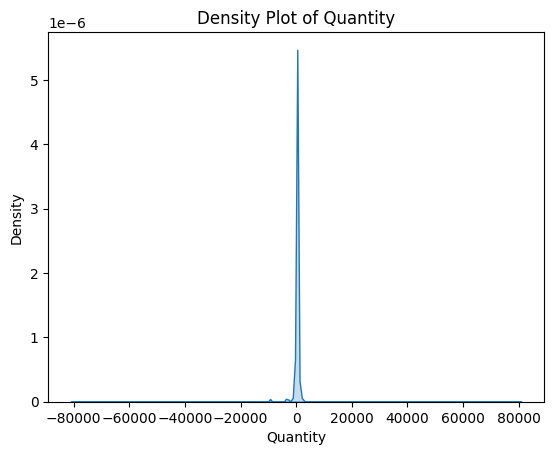

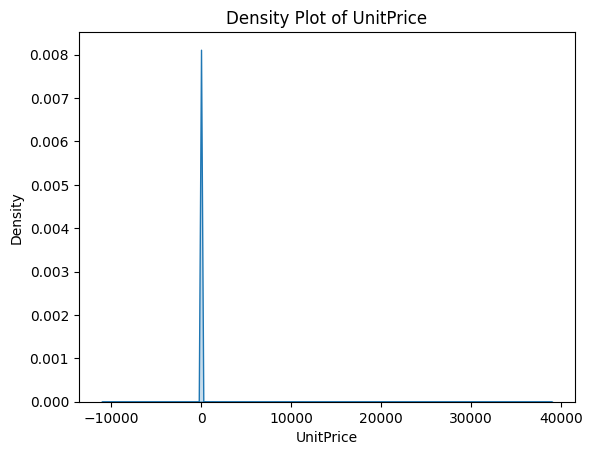

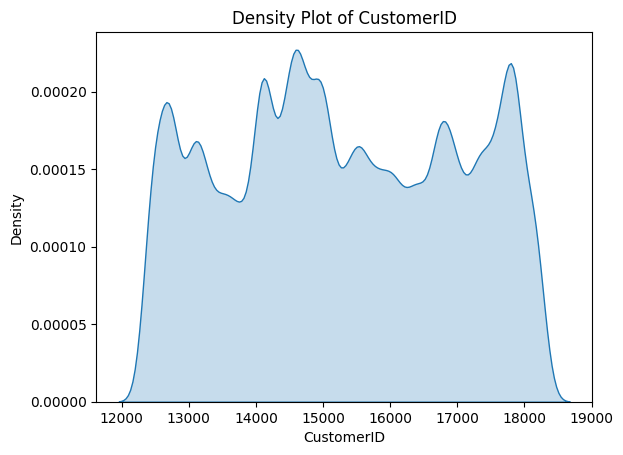

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

# Fetch dataset
online_retail = fetch_ucirepo(id=352)

# Extract features and combine into a single dataframe
df = pd.concat([online_retail.data.features, online_retail.data.targets], axis=1)

# Select numerical columns
numeric_cols = df.select_dtypes(include='number').columns

# Plot density for each numeric column
for col in numeric_cols:
    sns.kdeplot(df[col], fill=True)
    plt.title(f'Density Plot of {col}')
    plt.show()


### 2. Identify clusters in scatter plots
We'll use scatter plots to visually assess cluster formation between numerical features like `Quantity` and `UnitPrice`.





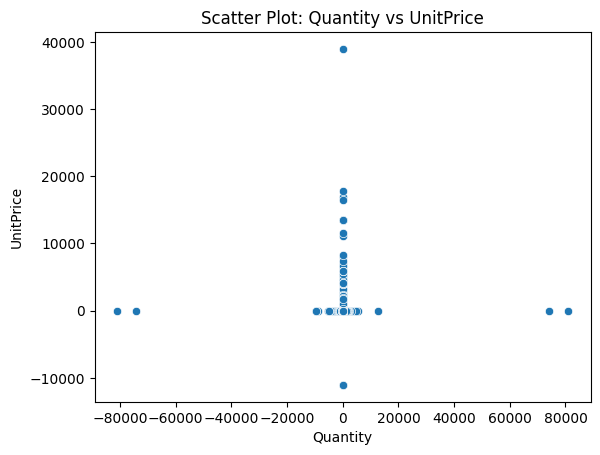

In [ ]:
# Scatter plot to identify clusters
sns.scatterplot(data=df, x='Quantity', y='UnitPrice')
plt.title('Scatter Plot: Quantity vs UnitPrice')
plt.show()


### 3. Clusters related to your decision tree model?


The clusters observed are expected to influence decision boundaries in the tree model. We will verify this in Part 2 by checking how the model splits on Quantity and UnitPrice.


### 4. Balance of the dependent variable
Examine if the 'Country' variable is balanced.


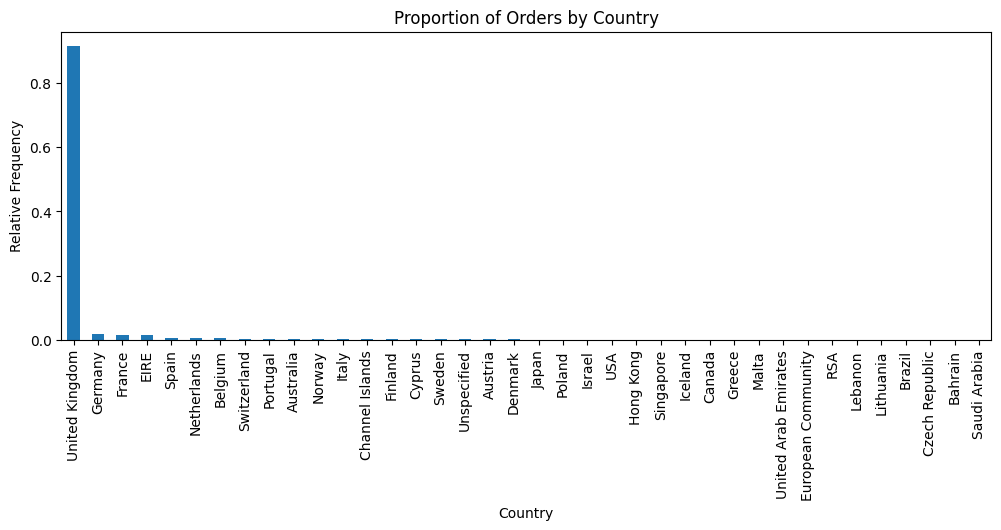

In [ ]:
# Count and plot class distribution for 'Country'
df['Country'].value_counts(normalize=True).plot(kind='bar', figsize=(12,4))
plt.title('Proportion of Orders by Country')
plt.ylabel('Relative Frequency')
plt.xticks(rotation=90)
plt.show()


The class distribution is highly imbalanced. The majority of transactions are from the "United Kingdom," while other countries have significantly fewer records. This imbalance will likely bias the decision tree toward the dominant class.


# Part 2

### 1. Build an unrestricted decision tree classifier
We will use `Country` as the target variable to predict based on numerical features.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Use numerical features only
X = df[['Quantity', 'UnitPrice']]
y = df['Country']

# Remove missing target values
X = X[y.notna()]
y = y[y.notna()]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Full-depth tree
full_tree = DecisionTreeClassifier(random_state=42)
full_tree.fit(X_train, y_train)
y_pred = full_tree.predict(X_test)

accuracy_full = accuracy_score(y_test, y_pred)
print(f"Unrestricted Decision Tree Accuracy: {accuracy_full:.2f}")


Unrestricted Decision Tree Accuracy: 0.91


### 2. Simplify the tree accuracy
Loop to find the smallest tree that retains at least 80% of the full tree's accuracy.


In [ ]:
threshold = 0.8 * accuracy_full

for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    if acc >= threshold:
        print(f"Simplified tree at depth {depth} meets accuracy {acc:.2f}")
        break

simple_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
simple_tree.fit(X_train, y_train)


Simplified tree at depth 1 meets accuracy 0.91


DecisionTreeClassifier(max_depth=1, random_state=42)

We found that a tree with depth **1** achieves **0.91** accuracy, which exceeds the 0.80 threshold (80% of the unrestricted model's accuracy). This tree is highly interpretable and generalizes well.


### 3. Do the models agree on major patterns?



In [ ]:
# Agreement check
y_simple_pred = simple_tree.predict(X_test)
agreement = (y_pred == y_simple_pred).mean()
print(f"Agreement between models: {agreement:.2f}")


Agreement between models: 0.99


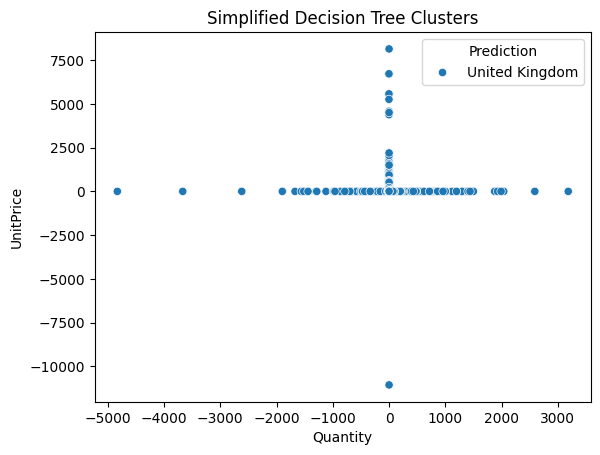

In [ ]:
import numpy as np

# Predict and color by simplified model
df_plot = X_test.copy()
df_plot['Prediction'] = simple_tree.predict(X_test)

sns.scatterplot(data=df_plot, x='Quantity', y='UnitPrice', hue='Prediction', palette='tab20')
plt.title('Simplified Decision Tree Clusters')
plt.show()


The simplified model splits along `Quantity` and `UnitPrice`, which matches earlier visual cluster groupings. These decision regions make intuitive sense given the business context of transactions.
